## MADlib Greenplum Demo
---

### Import neccessary Data Science libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)

Connect to Greenplum Database

In [2]:
%load_ext sql

In [3]:
!minikube service list

|-------------|------------------------------------------------------|--------------|------------------------------|
|  NAMESPACE  |                         NAME                         | TARGET PORT  |             URL              |
|-------------|------------------------------------------------------|--------------|------------------------------|
| default     | agent                                                | No node port |
| default     | greenplum                                            | psql/5432    | http://192.168.133.128:32000 |
| default     | greenplum-validating-webhook-service-9d44d9fcf-t26tq | No node port |
| default     | kubernetes                                           | No node port |
| default     | my-greenplum-pl                                      | No node port |
| default     | my-greenplum-pxf                                     | No node port |
| kube-system | kube-dns                                             | No node port |
|-------------|-

In [4]:
%sql postgresql://gpadmin@192.168.133.128:32000/db

/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Check Database Data

In [5]:
%%sql


SELECT COUNT(*) AS num_sample FROM sensors;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


num_sample
200000


In [6]:
%%sql

SELECT * FROM sensors LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
10 rows affected.


timestamp,temperature,humidity,pm25
1997-03-22 01:00:00,31.9156782671713,24.782009742474,97.5437132403095
1997-03-22 02:00:00,32.402048558739,34.1787819992172,84.3057449676734
1997-03-22 06:00:00,32.3448655378085,52.2063174021255,82.978271280186
1997-03-22 09:00:00,32.7567370123648,53.7069179335359,89.6222118646893
1997-03-22 11:00:00,30.7539767961126,47.1209740779875,75.7699431517518
1997-03-22 13:00:00,31.4872111517742,57.4849682913888,105.958693995633
1997-03-22 14:00:00,30.0627184404573,41.2363584988118,98.6599475653585
1997-03-22 15:00:00,32.5480766874707,43.2676695433859,69.6005951747951
1997-03-22 16:00:00,30.9466366403095,75.2501377422038,75.5936601995675
1997-03-22 17:00:00,32.740980874494,19.2678892981098,60.5962722602373


In [7]:
sensors = %sql SELECT * FROM sensors LIMIT 1000;
sensors = sensors.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
1000 rows affected.


In [8]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    1000 non-null   datetime64[ns]
 1   temperature  1000 non-null   float64       
 2   humidity     1000 non-null   float64       
 3   pm25         1000 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 31.4 KB


In [9]:
sensors.describe()

,temperature,humidity,pm25
count,1000.000000,1000.000000,1000.000000
mean,31.489820,50.124677,89.921600
std,0.865844,15.221467,14.985130
min,30.008730,-3.352847,38.065512
25%,30.758784,40.024476,80.168557
50%,31.487492,50.105209,90.444702
75%,32.217150,59.655244,100.254221
max,32.999716,102.371562,138.014441


/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


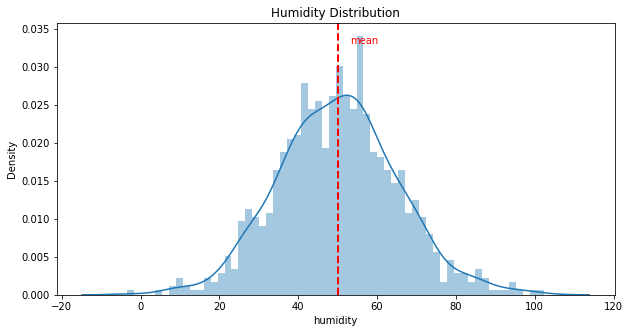

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(sensors['humidity'],bins=60);
plt.title("Humidity Distribution")
plt.axvline(x=sensors['humidity'].mean(),color='red',ls='--',lw=2)
plt.text(sensors['humidity'].mean()+3,0.033, "mean", fontsize=10,c='red');

### Preprocess Data

Encode Month

```sql
CREATE FUNCTION parse_month(time_stamp timestamp)
  RETURNS char
AS $$
  from datetime import datetime
  date_obj=datetime.strptime(time_stamp,"%Y-%m-%d %H:%M:%S")
  return date_obj.strftime("%B")
$$ LANGUAGE plpythonu;
```

In [11]:
%%sql
SELECT *,parse_month(timestamp) FROM sensors WHERE pm25 > 160;

 * postgresql://gpadmin@192.168.133.128:32000/db
3 rows affected.


timestamp,temperature,humidity,pm25,parse_month
1999-05-21 05:00:00,32.5355865309857,88.4879964462528,168.967536334876,May
2013-07-17 01:00:00,31.1730905372319,71.9060682541406,163.339759121527,July
2017-01-08 01:00:00,31.4313348104384,42.9120495893807,160.503965867301,January


Create Month Data

In [12]:
%%sql
DROP TABLE IF EXISTS sensors_pre;
CREATE TABLE sensors_pre
AS 
SELECT
    timestamp,
    temperature,
    humidity,
    pm25,
    parse_month(timestamp) AS month           --- Month data
FROM sensors;

SELECT * FROM sensors_pre LIMIT 10; 

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
200000 rows affected.
10 rows affected.


timestamp,temperature,humidity,pm25,month
1997-03-22 03:00:00,32.7490893859373,51.0368156042125,80.0859621571751,March
1997-03-22 08:00:00,32.7034745598259,54.435957921011,89.4230162813853,March
1997-03-22 10:00:00,31.2822157427365,43.258900909642,71.1791381057675,March
1997-03-22 23:00:00,30.3241848727147,54.7620749466587,106.203438251864,March
1997-03-23 02:00:00,30.349168442053,65.6500358536886,60.1286857288342,March
1997-03-25 19:00:00,30.6869189105232,84.769085231703,82.2315957027661,March
1997-03-26 03:00:00,30.6804192872696,44.0469280718854,86.597953294768,March
1997-03-26 08:00:00,31.336364293787,59.776236503862,75.7496274287744,March
1997-03-26 14:00:00,31.171969039765,60.6399419313433,117.966100069938,March
1997-03-26 19:00:00,32.219410318666,33.5853746184289,72.6441343323016,March


In [13]:
%%sql
SELECT parse_month(timestamp) as month ,COUNT(*) as count  
    FROM sensors  
GROUP BY month ORDER BY count DESC;

 * postgresql://gpadmin@192.168.133.128:32000/db
12 rows affected.


month,count
December,17112
May,17112
August,17112
July,17112
October,17112
January,16688
March,16608
November,16560
June,16560
April,16560


### Encode categorical values

In [18]:
%%sql
DROP TABLE IF EXISTS sensors_encoded;


SELECT
madlib.encode_categorical_variables (
    'sensors_pre',
    'sensors_encoded',
    'month',
    NULL,  --categorical_cols_to_exclude    -- Optional
    NULL,  --row_id,                         -- Optional
    NULL,  --top,                            -- Optional
    NULL,  --value_to_drop,                  -- Optional
    NULL,  --encode_null,                    -- Optional
    NULL,  --output_type,                    -- Optional
    NULL,  --output_dictionary,              -- Optional
    NULL   --distributed_by                  -- Optional
);


SELECT * FROM sensors_encoded LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


timestamp,temperature,humidity,pm25,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
1997-03-23 23:00:00,32.0490805882528,48.4857987448638,87.7070175357443,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-25 09:00:00,31.4291653616611,26.3422929359378,90.6952876831347,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-25 13:00:00,31.0494893815383,27.4131557171208,96.6949954481173,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-26 12:00:00,31.9004691105391,26.7281171205512,74.5060333410696,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-26 16:00:00,31.9071138139401,49.4345679826272,116.634221175262,0,0,0,0,0,0,0,1,0,0,0,0


### EDA

In [43]:
%%sql
DROP TABLE IF EXISTS sensors_summary ;
SELECT madlib.summary (
    'sensors_encoded',  -- source_table
    'sensors_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
);

SELECT * FROM sensors_summary LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,"""timestamp""",1,timestamp,200000,200000,0,None,0.0,None,None,None,None,None,None,None,None,None,None,None,None,"['2019-07-25 11:00:00', '2019-11-03 16:00:00', '2019-03-06 17:00:00', '2019-01-25 21:00:00', '2019-03-16 11:00:00', '2019-05-19 00:00:00', '2019-11-29 00:00:00', '2020-01-03 09:00:00', '2019-11-30 16:00:00', '2019-10-16 20:00:00']","[201, 198, 197, 197, 197, 196, 195, 195, 195, 194]"
None,None,temperature,2,float8,200000,200000,0,None,0.0,None,200000,0,0,32.000453033628,0.831157383268362,"[31.9964574271637, 32.0044486400923]",30.0087298079923,33.9961928500453,31.2517206487026,32.0021098528758,32.7494999153099,"['33.1461636555649', '31.865150292487', '31.1721536077699', '32.5851814378496', '33.3058162669061', '32.0454112936913', '33.8449270732997', '31.5729206121158', '31.1262156027079', '33.7836460827616']","[205, 199, 197, 197, 197, 196, 194, 193, 193, 193]"
None,None,humidity,3,float8,200000,200000,0,None,0.0,None,199912,88,0,49.9738552733267,225.487435610969,"[49.9080437039546, 50.0396668426987]",-17.8837665003152,117.73753974351,39.8194624583702,49.9930169092084,60.1088796662953,"['40.7345502178186', '58.4079913885737', '58.260773838973', '82.1523338384195', '49.3482258550915', '62.5528355417665', '56.9462840559174', '57.1599383222525', '23.3900957817855', '62.1840602115122']","[203, 199, 198, 196, 196, 196, 196, 196, 196, 195]"
None,None,pm25,4,float8,200000,200000,0,None,0.0,None,200000,0,0,94.9918835226586,233.682261133518,"[94.92488674011, 95.0588803052071]",30.3268689708454,168.967536334876,84.7204070035316,95.0517192454379,105.296417856079,"['126.921741983321', '97.7999835218195', '106.758793211523', '106.287416909122', '91.8541447897074', '106.908255032401', '64.5990923152777', '103.274370840996', '103.055030189882', '101.122630124362']","[204, 202, 200, 197, 197, 195, 195, 195, 195, 195]"
None,None,"""month_April""",5,int4,200000,2,0,None,0.0,None,16560,0,183440,0.0828,0.0759445397226986,"[0.0815922157812781, 0.0840077842187219]",0.0,1.0,0.0,0.0,0.0,"['0', '1']","[183440, 16560]"


### Correlation

In [5]:
%%sql
DROP TABLE IF EXISTS sensors_correlations;
DROP TABLE IF EXISTS sensors_correlations_summary;

SELECT 
madlib.correlation(
    'sensors_encoded', -- source_table
    'sensors_correlations',  -- target_table
    'temperature,humidity,pm25',
    TRUE -- verbose
)

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = sensors_correlationsProducing correlation for columns: temperature,humidity,pm25Total run time = ('sensors_correlations', 3, 2.707087993621826)"


In [8]:
Index = %sql SELECT variable FROM sensors_correlations;
Index = Index.DataFrame();

columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

 * postgresql://gpadmin@192.168.133.128:32000/db
3 rows affected.
humidity,pm25,temperature


In [19]:
corr = %sql select variable,{columns} from sensors_correlations;
corr = corr.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
3 rows affected.


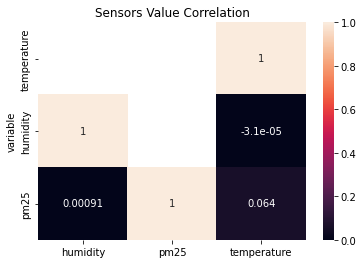

In [22]:
corr_df=corr.set_index('variable')
plt.title('Sensors Value Correlation')
sns.heatmap(corr_df,annot=True);